In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_labels(source_dir: str, datasets: list) -> dict:

    d_labels = {}
    for dataset, n_folds in datasets:
        d_labels[dataset] = {
            "train": [],
            "test": []
        }
        for fold in np.arange(n_folds):

            labels_dir = f"{source_dir}/datasets/labels/split_{n_folds}/{dataset}/{fold}"
            d_labels[dataset]["train"].append(
                np.load(f"{labels_dir}/train.npy"))
            d_labels[dataset]["test"].append(np.load(f"{labels_dir}/test.npy"))

    return d_labels


def load_probas(source_dir: str, datasets: list, clf_set: list) -> dict:
    d_probas = {}
    # For each dataset.
    for dataset, n_folds in datasets:
        d_probas[dataset] = {}
        # For each CLF.
        for clf, proba_type in clf_set:
            # If clf not in d_probas yet.
            if clf not in d_probas:
                d_probas[dataset][clf] = {}
            # For each fold.
            for fold in np.arange(n_folds):
                probas_dir = f"{source_dir}/{proba_type}/split_{n_folds}/{dataset}/{n_folds}_folds/{clf}/{fold}"

                if f"train" not in d_probas[dataset][clf]:
                    d_probas[dataset][clf]["train"] = []
                d_probas[dataset][clf]["train"].append(
                    np.load(f"{probas_dir}/train.npz")["X_train"])

                if f"test" not in d_probas[dataset][clf]:
                    d_probas[dataset][clf]["test"] = []
                d_probas[dataset][clf]["test"].append(
                    np.load(f"{probas_dir}/test.npz")["X_test"])

            d_probas[dataset][clf]
    return d_probas


In [3]:
DATASETS = [["acm", 10], ["20ng", 10]]

CLFS_SET = [
    ["bert", "temperature_scaling"],
    ["xlnet", "temperature_scaling"],
    ["ktmk", "isotonic"],
    ["ktr", "isotonic"],
    ["lstmk", "isotonic"],
    ["lstr", "isotonic"],
    ["ltr", "isotonic"]
]
CLFS_SET.sort(key=lambda x: x[0])

FEATURES_SET = [
    "centroids-ratios",
    "dist-20",
    "neigborhood",
    "probas",
    "probas-based",
    "bert"
]

FEATURES_SET.sort()
STACKING_DIR = "/home/welton/data/stacking/stacking_output"
meta_layer = "multi_output"

idx_to_clf = {idx: clf for idx, (clf, _) in enumerate(CLFS_SET)}


In [4]:
clf_sufix = '/'.join([ f"{c[0]}_{c[1]}" for c in CLFS_SET ])
mf_sufix = '_'.join(FEATURES_SET)

clf_sufix, mf_sufix

('bert_temperature_scaling/ktmk_isotonic/ktr_isotonic/lstmk_isotonic/lstr_isotonic/ltr_isotonic/xlnet_temperature_scaling',
 'bert_centroids-ratios_dist-20_neigborhood_probas_probas-based')

In [5]:
DATA_SOURCE = "/home/welton/data"
STACKING_DIR = f"{DATA_SOURCE}/stacking/stacking_output"

In [6]:
probas = load_probas(DATA_SOURCE, DATASETS, CLFS_SET)

In [7]:
labels = load_labels(DATA_SOURCE, DATASETS)

In [8]:
labels["acm"]["test"][0] == labels["acm"]["test"][1]

/tmp/ipykernel_27939/3438345539.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  labels["acm"]["test"][0] == labels["acm"]["test"][1]


False

In [9]:
preds = {}
for dataset, n_folds in DATASETS:
    preds[dataset] = {}
    for clf in probas[dataset]:
        preds[dataset][clf] = {
            "train": [],
            "test": []
        }
        for fold in np.arange(n_folds):
            preds[dataset][clf]["train"].append(probas[dataset][clf]["train"][fold].argmax(axis=1))
            preds[dataset][clf]["test"].append(probas[dataset][clf]["test"][fold].argmax(axis=1))

In [10]:
total_hits = {}
for dataset, n_folds in DATASETS:
    total_hits[dataset] = {
        "train": [],
        "test": []
    }
    for fold in np.arange(n_folds):
        contrasts_train, contrasts_test = [], []
        for clf in probas[dataset]:
            contrasts_train.append(preds[dataset][clf]["train"][fold] == labels[dataset]["train"][fold])
            contrasts_test.append(preds[dataset][clf]["test"][fold] == labels[dataset]["test"][fold])
        total_hits[dataset]["train"].append(np.sum(np.vstack(contrasts_train).T, axis=1))
        total_hits[dataset]["test"].append(np.sum(np.vstack(contrasts_test).T, axis=1))
total_hits
        

{'acm': {'train': [array([0, 6, 7, ..., 1, 7, 1]),
   array([0, 7, 7, ..., 7, 0, 1]),
   array([0, 7, 7, ..., 0, 7, 0]),
   array([0, 6, 7, ..., 7, 0, 7]),
   array([0, 7, 7, ..., 0, 7, 0]),
   array([7, 7, 7, ..., 0, 7, 0]),
   array([0, 7, 7, ..., 0, 7, 0]),
   array([0, 7, 7, ..., 0, 7, 0]),
   array([0, 7, 7, ..., 7, 7, 0]),
   array([0, 6, 7, ..., 0, 7, 0])],
  'test': [array([7, 7, 6, ..., 2, 7, 7]),
   array([7, 0, 5, ..., 7, 7, 7]),
   array([7, 7, 0, ..., 0, 7, 0]),
   array([7, 4, 3, ..., 0, 4, 0]),
   array([7, 7, 7, ..., 1, 7, 0]),
   array([0, 7, 0, ..., 0, 5, 6]),
   array([7, 7, 7, ..., 0, 7, 7]),
   array([6, 6, 7, ..., 0, 0, 7]),
   array([1, 7, 7, ..., 4, 7, 0]),
   array([7, 2, 7, ..., 0, 0, 6])]},
 '20ng': {'train': [array([7, 7, 1, ..., 7, 7, 7]),
   array([7, 7, 7, ..., 7, 7, 7]),
   array([7, 7, 1, ..., 4, 7, 7]),
   array([7, 7, 1, ..., 7, 7, 7]),
   array([7, 1, 4, ..., 1, 7, 7]),
   array([7, 7, 1, ..., 3, 7, 7]),
   array([7, 7, 1, ..., 7, 7, 7]),
   array([6

# Best CLF Fails Against Number of Classifiers hits.
Number of Meta layer's Missed docs by the number o classifiers hit. We use the Best CLF Meta Layer strategy as base.

In [11]:
counts_hits = {}
for dataset, n_folds in DATASETS:
    counts_hits[dataset] = {}
    for fold in np.arange(n_folds):
        loader = np.load(f"{STACKING_DIR}/{dataset}/{n_folds}_folds/{meta_layer}/{clf_sufix}/{mf_sufix}/fold_{fold}/output.npz")
        n_hits = set(total_hits[dataset]["test"][fold])
        hits = loader["y_pred"] != loader["y_test"]
        for c in n_hits:
            if c not in counts_hits[dataset]:
                counts_hits[dataset][c] = 0
            counts_hits[dataset][c] += np.sum(hits[total_hits[dataset]["test"][fold] == c])

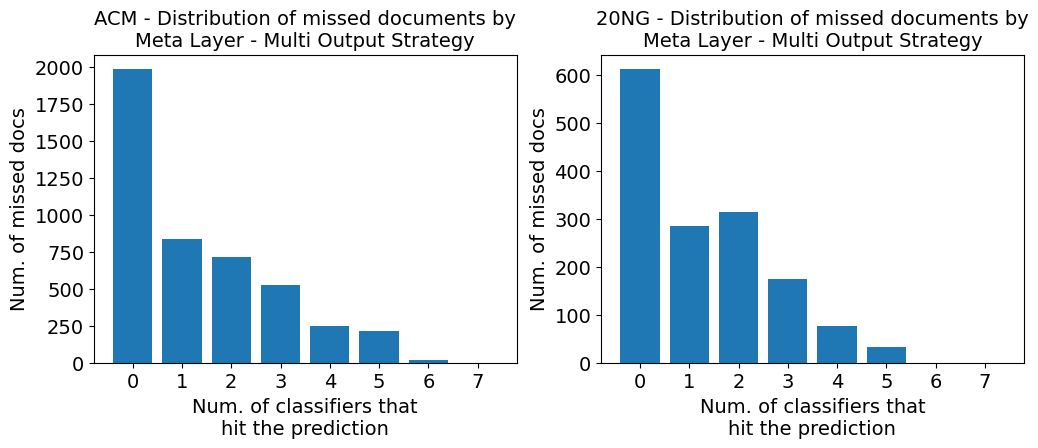

In [12]:
plt.figure(figsize=(12,4))
for plot_idx, (dataset, _) in enumerate(DATASETS):
    x = [ key for key in counts_hits[dataset] ]
    x.sort()
    y = [ counts_hits[dataset][key] for key in x ]
    plt.subplot(1, len(DATASETS), plot_idx + 1)
    plt.bar(x, y)
    plt.xticks(ticks=x, labels=x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Num. of classifiers that\nhit the prediction", fontsize=14)
    plt.ylabel("Num. of missed docs", fontsize=14)
    plt.title(f"{dataset.upper()} - Distribution of missed documents by\nMeta Layer - Multi Output Strategy", fontsize=14)

In [13]:
list(loader.keys())

['upper_test',
 'multi_best_clf_est',
 'best_est',
 'y_test',
 'y_train',
 'y_pred',
 'missed_train',
 'missed_test']

# Best CLF Selection Fails Against Number of Classifiers hits.
Number of Best CLF selection docs by the number o classifiers hit. We use the Best CLF selection as base.

In [14]:
NORM = False

In [15]:
counts_hits = {}
normalizer = {}
for dataset, n_folds in DATASETS:
    counts_hits[dataset] = {}
    normalizer[dataset] = {}
    for fold in np.arange(n_folds):
        loader = np.load(f"{STACKING_DIR}/{dataset}/{n_folds}_folds/{meta_layer}/{clf_sufix}/{mf_sufix}/fold_{fold}/output.npz")
        
        n_hits = set(total_hits[dataset]["test"][fold])
        
        misses = loader["upper_test"] != loader["best_est"]
        
        for c in n_hits:
            
            hits_with_c = total_hits[dataset]["test"][fold] == c
            if c not in counts_hits[dataset]:
                counts_hits[dataset][c] = 0

            counts_hits[dataset][c] += np.sum(misses[hits_with_c])

            if c not in normalizer[dataset]:
                normalizer[dataset][c] = 0
            normalizer[dataset][c] += np.sum(hits_with_c)
            
            #print(np.sum(misses[hits_with_c]), np.sum(hits_with_c))
    
    if NORM:
        n_hits = probas[dataset]["bert"]["test"][0].shape[1]
        for c in np.arange(n_hits):
            if c in counts_hits[dataset]:
                counts_hits[dataset][c] = counts_hits[dataset][c] / normalizer[dataset][c]

/tmp/ipykernel_27939/1802931210.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  misses = loader["upper_test"] != loader["best_est"]


TypeError: 'bool' object is not subscriptable

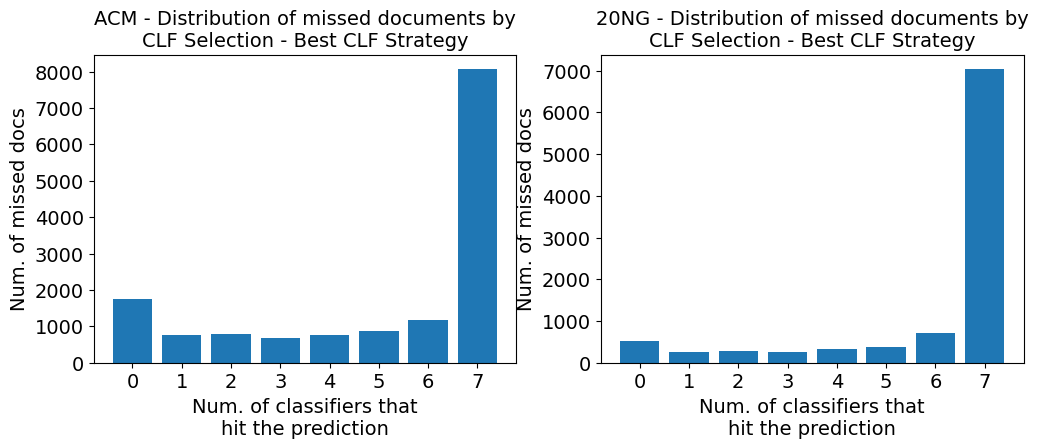

In [ ]:
plt.figure(figsize=(12,4))
for plot_idx, (dataset, n_folds) in enumerate(DATASETS):
    x = [ key for key in counts_hits[dataset] ]
    x.sort()
    y = [ counts_hits[dataset][key] for key in x ]
    plt.subplot(1, len(DATASETS), plot_idx + 1)
    plt.bar(x, y)
    plt.xticks(ticks=x, labels=x, fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel("Num. of classifiers that\nhit the prediction", fontsize=14)
    plt.ylabel(f"{'(%)' if NORM else 'Num.'} of missed docs", fontsize=14)
    plt.title(f"{dataset.upper()} - Distribution of missed documents by\nCLF Selection - Best CLF Strategy", fontsize=14)